In [3]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined IMAGE_HEIGHT, IMAGE_WIDTH, SEQUENCE_LENGTH, CLASSES_LIST,
# features_train, labels_train, features_test, labels_test

In [4]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [5]:
# Classes Directories
NonViolnceVideos_Dir = r"C:\Users\sathv\Downloads\mini\RealLifeViolenceDataset\NonViolence"
ViolnceVideos_Dir = r"C:\Users\sathv\Downloads\mini\RealLifeViolenceDataset\Violence"

# Retrieve the list of all the video files present in the Class Directory.
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

# Randomly select a video file from the Classes Directory.
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [6]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [7]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [8]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16
 

DATASET_DIR = r"C:\Users\sathv\Downloads\mini\RealLifeViolenceDataset"
 
CLASSES_LIST = ["NonViolence","Violence"]

In [9]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [10]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [11]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [12]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


In [13]:
def create_vgg16_model():
    """
    Creates a VGG16 based model for video classification.
    """
    vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    # Freeze the layers in the base model
    for layer in vgg16_base.layers:
        layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(vgg16_base, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

In [14]:
# Constructing the VGG16 Model
VGG16_model = create_vgg16_model()

C:\Users\sathv\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 2, 2, 512)  │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,770 (58.26 MB)

 Trainable params: 558,082 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
# Create Early Stopping Callback
vgg16_early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Create ReduceLROnPlateau Callback
vgg16_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.6,
                                                    patience=5,
                                                    min_lr=0.00005,
                                                    verbose=1)

In [16]:
# Compiling the VGG16 model
VGG16_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [17]:
# Fitting the VGG16 model
VGG16_model_history = VGG16_model.fit(x=features_train, y=labels_train, epochs=10, batch_size=8,
                                      shuffle=True, validation_split=0.2,
                                      callbacks=[vgg16_early_stopping_callback, vgg16_reduce_lr])

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.5110 - loss: 0.7307 - val_accuracy: 0.6028 - val_loss: 0.6600 - learning_rate: 0.0100
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 478s 3s/step - accuracy: 0.5776 - loss: 0.6704 - val_accuracy: 0.6722 - val_loss: 0.6305 - learning_rate: 0.0100
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.6105 - loss: 0.6439 - val_accuracy: 0.6917 - val_loss: 0.5958 - learning_rate: 0.0100
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.6432 - loss: 0.6236 - val_accuracy: 0.7167 - val_loss: 0.5732 - learning_rate: 0.0100
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.6842 - loss: 0.6006 - val_accuracy: 0.7139 - val_loss: 0.5875 - learning_rate: 0.0100
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 474s 3s/step - accuracy: 0.6750 - loss: 0.5849 - val_accuracy: 0.7472 - val_loss: 0.5266 - learning_rate: 0.0100
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.7201 - loss: 0.

In [18]:
# Evaluating the VGG16 model
vgg16_model_evaluation_history = VGG16_model.evaluate(features_test, labels_test)
print(f"VGG16 Test Accuracy: {vgg16_model_evaluation_history[1]:.4f}")
print(f"VGG16 Test Loss: {vgg16_model_evaluation_history[0]:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - accuracy: 0.6710 - loss: 0.6132
VGG16 Test Accuracy: 0.7000
VGG16 Test Loss: 0.5864


In [64]:
# After training
VGG16_model.save_weights("vgg16_model.weights.h5")


In [68]:
# Step 1: Recreate the model architecture
VGG16_model = create_vgg16_model()

# Step 2: Load the trained weights
VGG16_model.load_weights("vgg16_model.weights.h5")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 16, 2, 2, 512)  │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,272,770 (58.26 MB)

 Trainable params: 558,082 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [74]:
VGG16_model.save("vgg16_model.keras")  # New format (recommended)


In [76]:
from tensorflow.keras.models import load_model

VGG16_model = load_model("vgg16_model.keras")


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

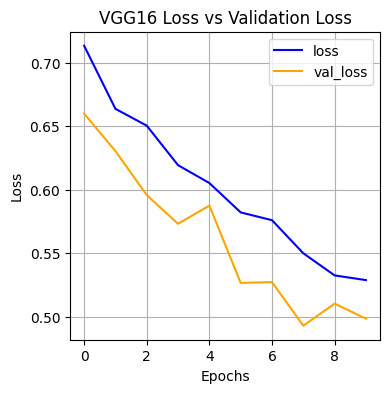

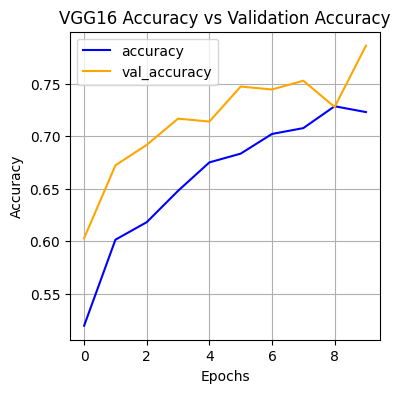

In [20]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.figure(figsize=(4, 4))
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.xlabel("Epochs")
    plt.ylabel(metric_name_1.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the metrics for VGG16
plot_metric(VGG16_model_history, 'loss', 'val_loss', 'VGG16 Loss vs Validation Loss')
plot_metric(VGG16_model_history, 'accuracy', 'val_accuracy', 'VGG16 Accuracy vs Validation Accuracy')

7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 9s/step
Classification Report:
               precision    recall  f1-score   support

 NonViolence       0.67      0.55      0.60        99
    Violence       0.62      0.73      0.67       101

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.64      0.64       200

Confusion Matrix:
 [[54 45]
 [27 74]]


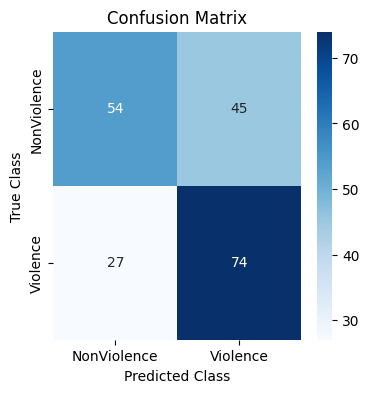

In [105]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = VGG16_model.predict(features_test)

# Convert one-hot encoded predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class labels
true_classes = np.argmax(labels_test, axis=1)

# Generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST)
print("Classification Report:\n", report)

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)



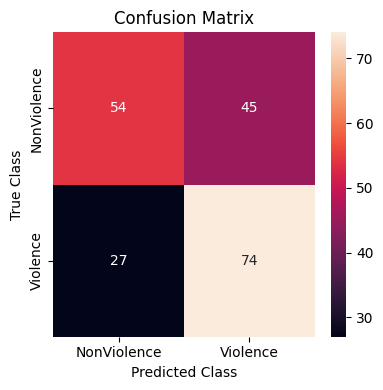

In [109]:
# Visualize the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='g',
            xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [97]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load your trained model
model = load_model("vgg16_model.keras")

def preprocess_frames(frames):
    processed_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_frame = resized_frame.astype("float32")
        normalized_frame = preprocess_input(normalized_frame)
        processed_frames.append(normalized_frame)
    return np.array(processed_frames)

def predict_video_class(video_path, model):
    frames = []
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    while success:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        success, frame = cap.read()
    cap.release()

    # If total frames < SEQUENCE_LENGTH, pad by repeating last frame
    if len(frames) < SEQUENCE_LENGTH:
        frames += [frames[-1]] * (SEQUENCE_LENGTH - len(frames))
    
    # Sample SEQUENCE_LENGTH evenly spaced frames
    total_frames = len(frames)
    skip_frames_window = max(1, total_frames // SEQUENCE_LENGTH)
    sampled_frames = [frames[i] for i in range(0, total_frames, skip_frames_window)][:SEQUENCE_LENGTH]

    # Preprocess frames
    preprocessed_frames = preprocess_frames(sampled_frames)
    input_tensor = np.expand_dims(preprocessed_frames, axis=0)  # (1, 16, 64, 64, 3)

    prediction = model.predict(input_tensor)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    print(f"Predicted Class: {CLASSES_LIST[predicted_class]}")
    print(f"Confidence: {confidence:.2f}")



In [101]:
# Test the model on a video
test_video_path = r"C:\Users\sathv\Downloads\NV.avi"
predict_video_class(test_video_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: NonViolence
Confidence: 0.58


In [103]:
# Test the model on a video
test_video_path = r"C:\Users\sathv\Downloads\NVV.avi"
predict_video_class(test_video_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Predicted Class: NonViolence
Confidence: 0.68
